In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [40]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import h5py
from tqdm import tqdm
from skimage.util import img_as_ubyte
from sklearn.metrics import pairwise_distances

from utils import set_up_environment, prewhiten, l2_normalize

In [24]:
set_up_environment(visible_devices='1')

In [4]:
dataset_directory = '/projects/leelab3/image_datasets/vgg_face/test_preprocessed'
identities = os.listdir(dataset_directory)

In [ ]:
model_path = '../facenet_keras.h5'
model = tf.keras.models.load_model(model_path)

In [91]:
def get_embeddings(identity_index=0):
    image_file = os.path.join(dataset_directory,
                              identities[identity_index],
                              'images.h5')

    with h5py.File(image_file, 'r') as f:
        images = f['images'][:]

    images_whitened = prewhiten(images).astype(np.float32)
    embeddings = model.predict(images_whitened, batch_size=32)
    normalized_embeddings = l2_normalize(embeddings)
    return images, normalized_embeddings

In [92]:
images_0, embeddings_0 = get_embeddings(0)
images_1, embeddings_1 = get_embeddings(1)

In [55]:
intra_distances_0 = pairwise_distances(embeddings_0)
inter_distances_0_1 = pairwise_distances(embeddings_0, embeddings_1)

In [70]:
off_diag_mask = ~np.eye(intra_distances_0.shape[0], dtype=bool)
distances_vector_0 = intra_distances_0[off_diag_mask]

In [71]:
distances_vector_0_1 = inter_distances_0_1.flatten()

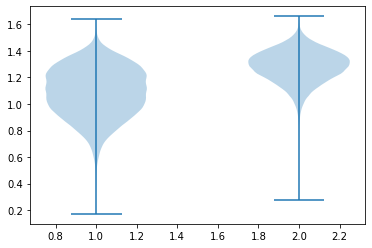

In [73]:
_ = plt.violinplot([distances_vector_0, distances_vector_0_1])

In [78]:
def accuracy_at_threshold(threshold):
    x = np.concatenate([distances_vector_0, distances_vector_0_1])
    y = np.array([1] * len(distances_vector_0) + [0] * len(distances_vector_0_1))
    predicted_y = (x < threshold).astype(y.dtype)
    return np.sum(y == predicted_y) / len(y)

In [79]:
thresholds = np.linspace(0.0, 2.0, 1000)
accuracy_at_threshold = [accuracy_at_threshold(t) for t in thresholds]

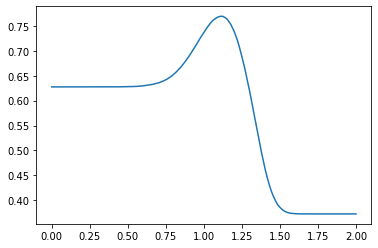

In [86]:
plt.plot(thresholds, accuracy_at_threshold)

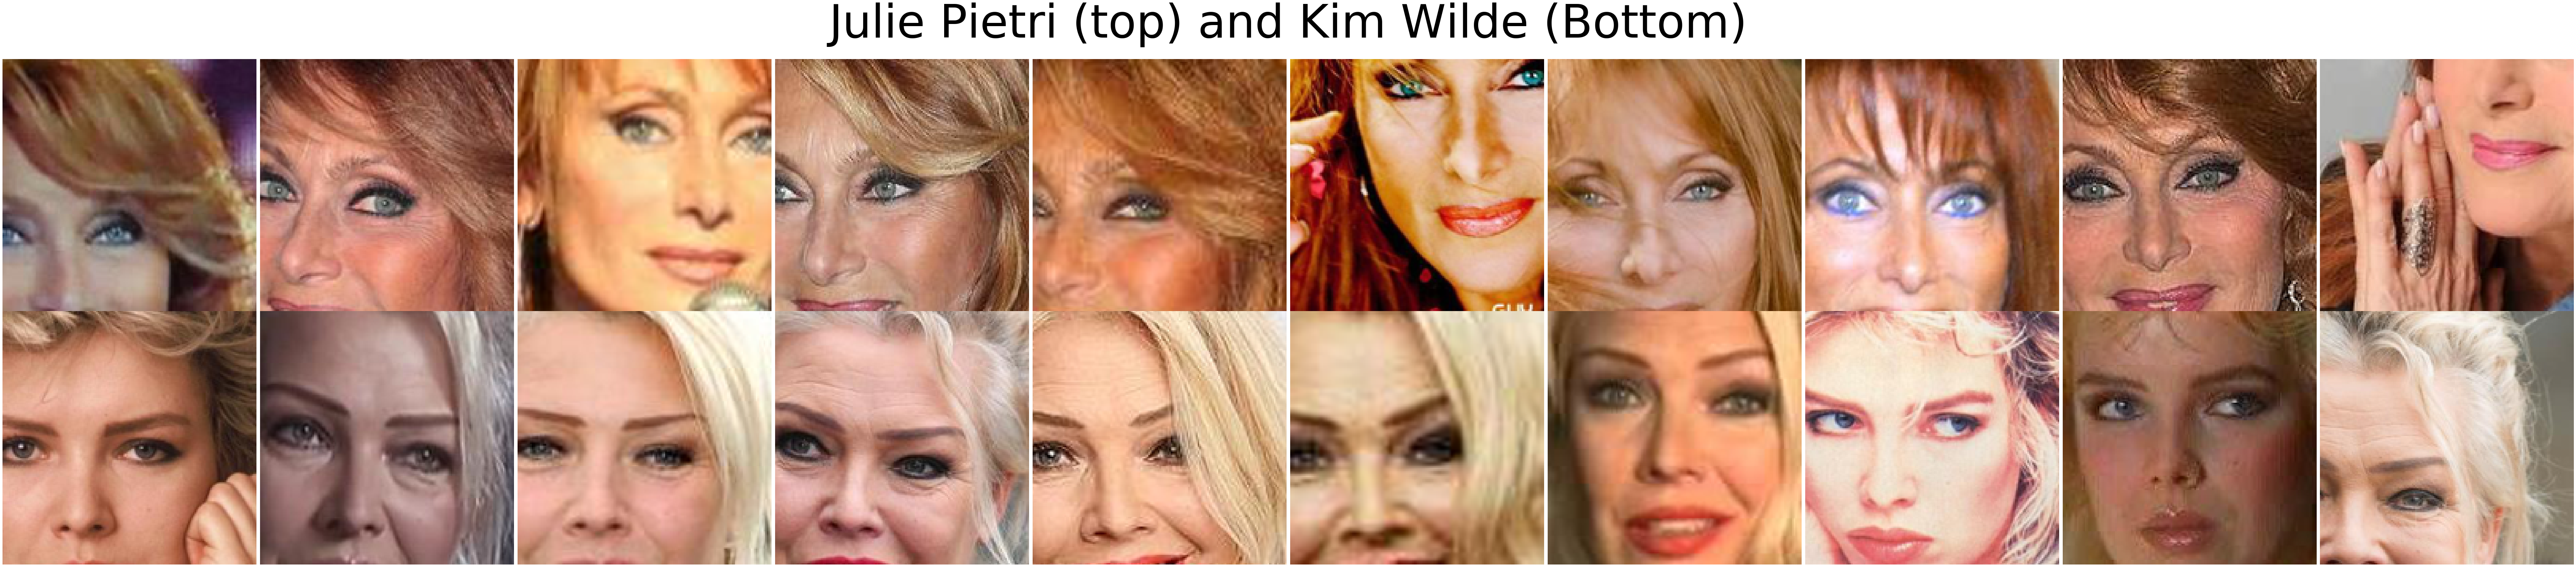

In [107]:
fig, axs = plt.subplots(2, 10, figsize=(100, 20))
for i in range(10):
    axs[0, i].imshow(images_0[i])
    axs[1, i].imshow(images_1[i])

    axs[0, i].axis('off')
    axs[1, i].axis('off')
_ = fig.tight_layout()
_ = plt.suptitle('Julie Pietri (top) and Kim Wilde (Bottom)', fontsize=128, y=1.10)